<a href="https://colab.research.google.com/github/kelseymatsik/ds4002_project2/blob/main/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [36]:
# ! git clone https://github.com/kelseymatsik/ds4002_project2

fatal: destination path 'ds4002_project2' already exists and is not an empty directory.


## Data Preprocessing

In [2]:
df = pd.read_csv("./cleaned_data.csv")

df.head(5)


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,ReportingOfficer,InSession,DayOfWeek,TimeOfDay_Adjusted,TimeOfDay
0,1,Assist Citizen,202400034093,900.0,"ELLIOTT AVE, A",CPD,2024-10-01 20:24:02-04:00,2024,"Venereo, Arturo",1,Tuesday,Dusk,Night
1,2,Larceny,202400034075,1600.0,"6TH ST SE, 28",CPD,2024-10-01 17:38:47-04:00,1738,"Kirby, Tyree",1,Tuesday,Noon,Night
2,3,Hit and Run,202400034071,900.0,EMMET ST N,CPD,2024-10-01 17:11:45-04:00,1711,"Bland, Johnnà",1,Tuesday,Noon,Night
3,4,Disorderly Conduct,202400034068,900.0,"ST CLAIR AVE, A",CPD,2024-10-01 16:59:17-04:00,1659,"Prevost, Payten",1,Tuesday,Noon,Night
4,5,Lost/FoundProperty,202400034047,700.0,RUGBY RD,CPD,2024-10-01 14:23:15-04:00,1423,"Brannon, Devin",1,Tuesday,Noon,Night


In [3]:
# Keep certain columns
columns_to_keep = ['RecordID', 'DateReported', 'InSession', 'DayOfWeek', 'TimeOfDay_Adjusted']
df = df[columns_to_keep]
df.head()

,RecordID,DateReported,InSession,DayOfWeek,TimeOfDay_Adjusted
0,1,2024-10-01 20:24:02-04:00,1,Tuesday,Dusk
1,2,2024-10-01 17:38:47-04:00,1,Tuesday,Noon
2,3,2024-10-01 17:11:45-04:00,1,Tuesday,Noon
3,4,2024-10-01 16:59:17-04:00,1,Tuesday,Noon
4,5,2024-10-01 14:23:15-04:00,1,Tuesday,Noon


In [4]:
df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce', utc=True)
if df['DateReported'].isnull().any():
    print("Warning: Some dates could not be parsed and were converted to NaT (Not a Time).")
    print(df[df['DateReported'].isnull()])
df['DaysSince2000'] = (df['DateReported'] - pd.Timestamp('2000-01-01', tz='UTC')).dt.days
df_encoded = pd.get_dummies(df, columns=['DayOfWeek', 'TimeOfDay_Adjusted'], drop_first=True)
df_encoded = df_encoded.drop(columns=['RecordID', 'DateReported', 'DaysSince2000'])
rest_of_df = df[['RecordID', 'DaysSince2000']]
df_final = pd.concat([rest_of_df, df_encoded], axis=1)
display(df_final.head())


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_9511/3872765721.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce', utc=True)


,RecordID,DaysSince2000,InSession,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,TimeOfDay_Adjusted_Dusk,TimeOfDay_Adjusted_Noon,TimeOfDay_Adjusted_Sunrise,TimeOfDay_Adjusted_Sunset
0,1,9041,1,False,False,False,False,True,False,True,False,False,False
1,2,9040,1,False,False,False,False,True,False,False,True,False,False
2,3,9040,1,False,False,False,False,True,False,False,True,False,False
3,4,9040,1,False,False,False,False,True,False,False,True,False,False
4,5,9040,1,False,False,False,False,True,False,False,True,False,False


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             CrimeCount   No. Observations:                 1825
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5684.542
Date:                Tue, 18 Mar 2025   AIC                          11385.084
Time:                        17:43:00   BIC                          11429.158
Sample:                    10-05-2019   HQIC                         11401.342
                         - 10-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.5286      0.462      1.145      0.252      -0.376       1.434
Saturday      -1.2293      0.328     -3.754      0.000      -1.871      -0.587
Sunday        -1.6275      0.426     -3.819      0.0

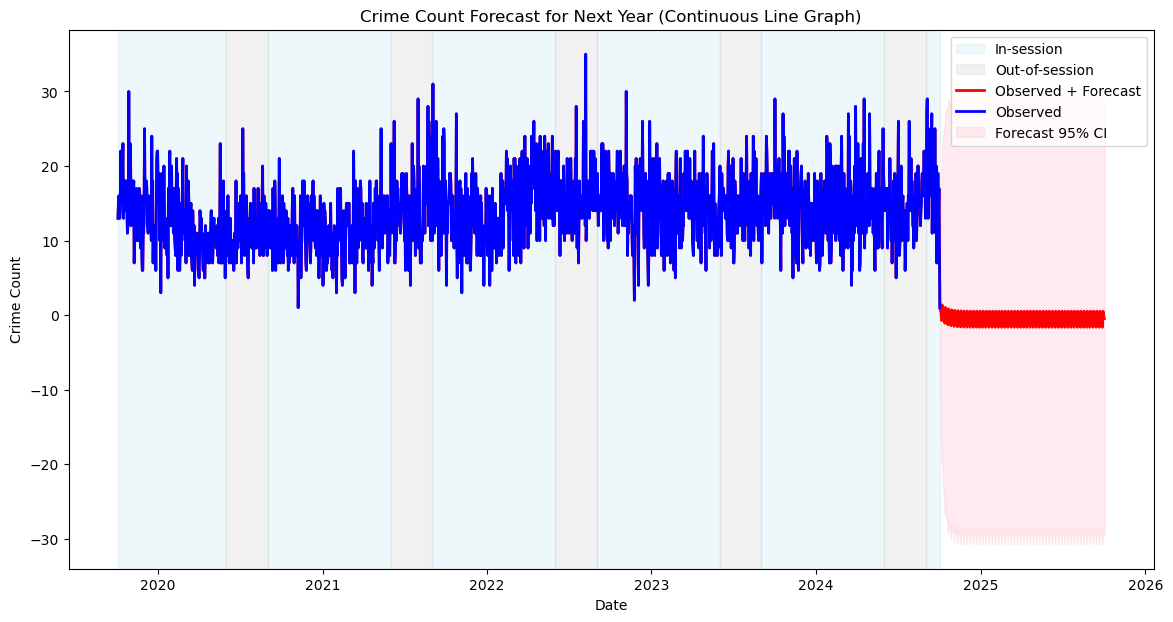

In [6]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Data Preparation: Convert dates, drop invalids, and aggregate daily crime counts.
df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce', utc=True)
df = df.dropna(subset=['DateReported'])
df['CrimeCount'] = 1
daily_df = df.groupby(df['DateReported'].dt.floor('D')).agg({'CrimeCount': 'sum'}).reset_index()
daily_df = daily_df.rename(columns={'DateReported': 'Date'})

# 2. Create day-of-week dummies for exogenous regressors.
daily_df['DayName'] = daily_df['Date'].dt.day_name()
daily_df.set_index('Date', inplace=True)
exog = pd.get_dummies(daily_df['DayName'], drop_first=True)
daily_df = daily_df.join(exog).drop(columns=['DayName']).sort_index()

# 3. Define endogenous and exogenous variables.
endog = daily_df[['CrimeCount']].astype(float)
exog_vars = daily_df.drop(columns=['CrimeCount']).astype(float)

# 4. Fit SARIMAX model (here an AR(1) is assumed as an example).
model = SARIMAX(endog, exog=exog_vars, order=(1, 0, 0))
results = model.fit(disp=False)
print(results.summary())

# 5. Forecast for the next year (365 days).
forecast_steps = 365
forecast_index = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq='D')
forecast_day_names = forecast_index.day_name()
forecast_exog = pd.get_dummies(forecast_day_names, drop_first=True)
forecast_exog = forecast_exog.reindex(columns=exog_vars.columns, fill_value=0)
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_df = forecast.summary_frame()

# 6. Combine observed and forecast values for a continuous line.
combined_index = endog.index.append(forecast_index)
combined_values = pd.concat([endog['CrimeCount'], forecast_df['mean']])

# 7. Plot the combined line graph along with the forecast confidence intervals.
plt.figure(figsize=(14, 7))

# Shade the observed period based on session status.
# (For example: out-of-session if month in [6,7,8], otherwise in-session.)
obs_dates = daily_df.index
obs_is_out = np.array([d.month in [6, 7, 8] for d in obs_dates])
in_session_label = None
out_session_label = None
for key, group in itertools.groupby(enumerate(obs_is_out), lambda x: x[1]):
    group = list(group)
    start_idx = group[0][0]
    end_idx = group[-1][0]
    start_date = obs_dates[start_idx]
    # Extend the interval to cover the last day.
    end_date = obs_dates[end_idx] + pd.Timedelta(days=1)
    if key:  # Out-of-session (June, July, August)
        if out_session_label is None:
            plt.axvspan(start_date, end_date, color='lightgray', alpha=0.3, label='Out-of-session')
            out_session_label = True
        else:
            plt.axvspan(start_date, end_date, color='lightgray', alpha=0.3)
    else:  # In-session
        if in_session_label is None:
            plt.axvspan(start_date, end_date, color='lightblue', alpha=0.2, label='In-session')
            in_session_label = True
        else:
            plt.axvspan(start_date, end_date, color='lightblue', alpha=0.2)

# Plot combined continuous line: This joins the observed data and forecast smoothly.
plt.plot(combined_index, combined_values, color='red', lw=2, label='Observed + Forecast')

# Also plot the observed data over the same interval in blue.
plt.plot(endog.index, endog['CrimeCount'], color='blue', lw=2, label='Observed')

# Plot the forecast confidence intervals.
plt.fill_between(forecast_index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3, label='Forecast 95% CI')

plt.title('Crime Count Forecast for Next Year (Continuous Line Graph)')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


# DOESN"T WORK BECAUSE INCLUDES LAST TIME WHICH IS INCOMPLETE

,CrimeCount,OutOfSession
Date,,
2019-10-31,438,0
2019-11-30,398,0
2019-12-31,435,0
2020-01-31,415,0
2020-02-29,376,0


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             CrimeCount   No. Observations:                   60
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -314.475
Date:                Tue, 18 Mar 2025   AIC                            634.950
Time:                        17:44:26   BIC                            641.233
Sample:                    10-31-2019   HQIC                           637.407
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
OutOfSession    -7.6952     16.208     -0.475      0.635     -39.462      24.072
ar.L1            0.9958      0.014     73.341      0.000       0.969       1.022
sigma2        1928.6521    490.641      3.93

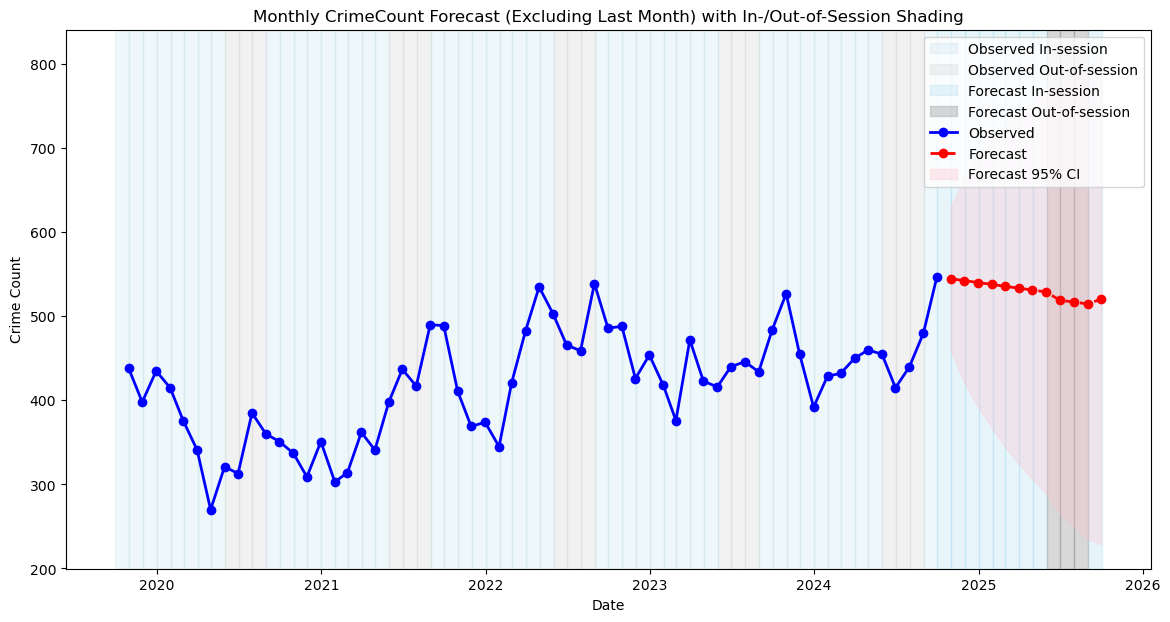

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------------------------
# Step 1: Data Preparation
# ---------------------------
df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce', utc=True)
df = df.dropna(subset=['DateReported'])
df['CrimeCount'] = 1

# ---------------------------
# Step 2: Aggregate by Month (using "ME" for month end)
# ---------------------------
monthly_df = df.groupby(pd.Grouper(key='DateReported', freq='ME')).agg({'CrimeCount': 'sum'}).reset_index()
monthly_df = monthly_df.rename(columns={'DateReported': 'Date'})
monthly_df.set_index('Date', inplace=True)

# Remove timezone info (to ease period conversions)
monthly_df.index = monthly_df.index.tz_localize(None)

# Exclude the last month (assuming it may be incomplete)
monthly_df = monthly_df.iloc[:-1]

# Create exogenous variable: OutOfSession = 1 if month in [6, 7, 8], else 0.
monthly_df['OutOfSession'] = monthly_df.index.month.isin([6, 7, 8]).astype(int)

display(monthly_df.head())

# ---------------------------
# Step 3: SARIMAX Modeling & Forecasting
# ---------------------------
endog = monthly_df[['CrimeCount']].astype(float)
exog_vars = monthly_df[['OutOfSession']].astype(float)

# Fit SARIMAX model (using AR(1) as an example)
model = SARIMAX(endog, exog=exog_vars, order=(1, 0, 0))
results = model.fit(disp=False)
print(results.summary())

# Forecast for the next 12 months
forecast_steps = 12
forecast_index = pd.date_range(
    start=monthly_df.index[-1] + pd.offsets.MonthEnd(),
    periods=forecast_steps,
    freq='ME'
)
forecast_out_session = forecast_index.month.isin([6, 7, 8]).astype(int)
forecast_exog = pd.DataFrame({'OutOfSession': forecast_out_session}, index=forecast_index)

forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_df = forecast.summary_frame()
print(forecast_df)

# ---------------------------
# Step 4: Plot Observed and Forecasted Monthly CrimeCount with Session Shading
# ---------------------------
plt.figure(figsize=(14, 7))

# Background shading for observed months
obs_in_label = False
obs_out_label = False
for date in monthly_df.index:
    period = date.to_period('M')
    month_start = period.start_time  # No parentheses
    month_end = period.end_time      # No parentheses
    if date.month in [6, 7, 8]:
        if not obs_out_label:
            plt.axvspan(month_start, month_end, color='lightgray', alpha=0.3, label='Observed Out-of-session')
            obs_out_label = True
        else:
            plt.axvspan(month_start, month_end, color='lightgray', alpha=0.3)
    else:
        if not obs_in_label:
            plt.axvspan(month_start, month_end, color='lightblue', alpha=0.2, label='Observed In-session')
            obs_in_label = True
        else:
            plt.axvspan(month_start, month_end, color='lightblue', alpha=0.2)

# Background shading for forecast months
fc_in_label = False
fc_out_label = False
for date in forecast_index:
    period = date.to_period('M')
    month_start = period.start_time  # Property access, not a call
    month_end = period.end_time      # Property access, not a call
    if date.month in [6, 7, 8]:
        if not fc_out_label:
            plt.axvspan(month_start, month_end, color='gray', alpha=0.3, label='Forecast Out-of-session')
            fc_out_label = True
        else:
            plt.axvspan(month_start, month_end, color='gray', alpha=0.3)
    else:
        if not fc_in_label:
            plt.axvspan(month_start, month_end, color='skyblue', alpha=0.2, label='Forecast In-session')
            fc_in_label = True
        else:
            plt.axvspan(month_start, month_end, color='skyblue', alpha=0.2)

# Plot observed monthly CrimeCount
plt.plot(monthly_df.index, monthly_df['CrimeCount'], color='blue', lw=2, marker='o', label='Observed')

# Plot forecasted monthly mean values
plt.plot(forecast_index, forecast_df['mean'], color='red', lw=2, linestyle='--', marker='o', label='Forecast')

# Plot forecast confidence intervals
plt.fill_between(forecast_index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3, label='Forecast 95% CI')

plt.title('Monthly CrimeCount Forecast (Excluding Last Month) with In-/Out-of-Session Shading')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


In [62]:
df = pd.read_csv("./ds4002_project2/cleaned_data.csv")

df.head(5)


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,DateReported,HourReported,ReportingOfficer,InSession,DayOfWeek,TimeOfDay_Adjusted,TimeOfDay
0,1,Assist Citizen,202400034093,900.0,"ELLIOTT AVE, A",CPD,2024-10-01 20:24:02-04:00,2024,"Venereo, Arturo",1,Tuesday,Dusk,Night
1,2,Larceny,202400034075,1600.0,"6TH ST SE, 28",CPD,2024-10-01 17:38:47-04:00,1738,"Kirby, Tyree",1,Tuesday,Noon,Night
2,3,Hit and Run,202400034071,900.0,EMMET ST N,CPD,2024-10-01 17:11:45-04:00,1711,"Bland, Johnnà",1,Tuesday,Noon,Night
3,4,Disorderly Conduct,202400034068,900.0,"ST CLAIR AVE, A",CPD,2024-10-01 16:59:17-04:00,1659,"Prevost, Payten",1,Tuesday,Noon,Night
4,5,Lost/FoundProperty,202400034047,700.0,RUGBY RD,CPD,2024-10-01 14:23:15-04:00,1423,"Brannon, Devin",1,Tuesday,Noon,Night


In [ ]:
# weekly, day/night

Weekly Aggregated Data:
              NightCrimeCount  DayCrimeCount
DateReported                                
2019-10-06                 14             14
2019-10-13                 43             67
2019-10-20                 46             79
2019-10-27                 46             54
2019-11-03                 55             76

Night Crime SARIMAX Summary:
                               SARIMAX Results                                
Dep. Variable:        NightCrimeCount   No. Observations:                  261
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -963.644
Date:                Tue, 18 Mar 2025   AIC                           1931.289
Time:                        17:45:44   BIC                           1938.418
Sample:                    10-06-2019   HQIC                          1934.154
                         - 09-29-2024                                         
Covariance Type:                  opg                                         

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


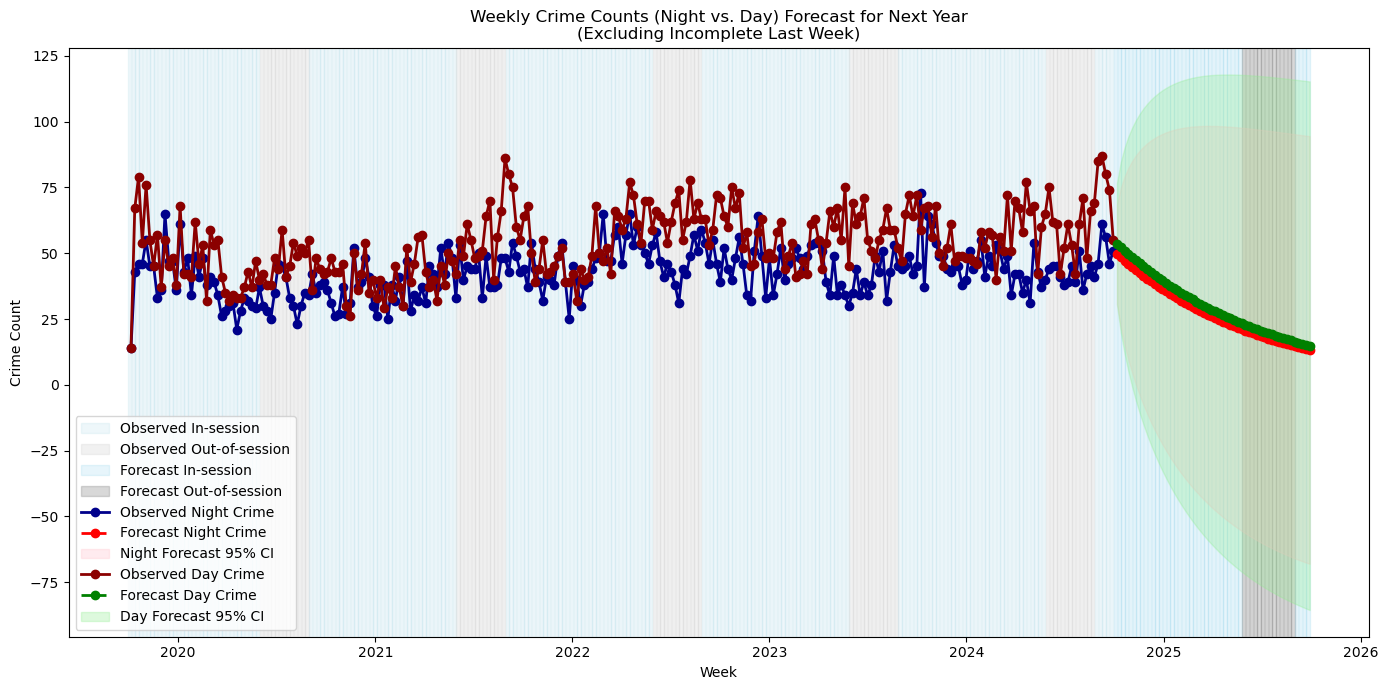

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------------------------
# Step 1: Data Preparation & Feature Engineering
# ---------------------------
df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce', utc=True)
df = df.dropna(subset=['DateReported'])

# Each event counts as one crime.
df['CrimeCount'] = 1

# Flag nighttime events: events at or after 8 PM or before 6 AM.
df['IsNight'] = df['DateReported'].dt.hour.apply(lambda x: (x >= 20) or (x < 6))

# ---------------------------
# Step 2: Exclude the Last Incomplete Week
# ---------------------------
# Compute the maximum timestamp in the raw data and make it tz-naive.
max_data_date = df['DateReported'].max().tz_localize(None)

# ---------------------------
# Step 3: Weekly Aggregation
# ---------------------------
# Aggregate weekly nighttime crimes.
weekly_night = (
    df[df['IsNight']]
    .groupby(pd.Grouper(key='DateReported', freq='W'))
    .agg({'CrimeCount': 'sum'})
    .rename(columns={'CrimeCount': 'NightCrimeCount'})
)

# Aggregate weekly daytime crimes.
weekly_day = (
    df[~df['IsNight']]
    .groupby(pd.Grouper(key='DateReported', freq='W'))
    .agg({'CrimeCount': 'sum'})
    .rename(columns={'CrimeCount': 'DayCrimeCount'})
)

# Merge the two series and fill missing weeks with 0.
weekly_df = weekly_night.join(weekly_day, how='outer').fillna(0).sort_index()

# Ensure the weekly index is tz-naive.
if weekly_df.index.tz is not None:
    weekly_df.index = weekly_df.index.tz_localize(None)

# The weekly aggregation index represents the week end (typically Sunday).
# Exclude the last week if it is incomplete (i.e. if max_data_date is before the week-end).
last_week_end = weekly_df.index[-1]
if max_data_date < last_week_end:
    weekly_df = weekly_df.iloc[:-1]

print("Weekly Aggregated Data:")
print(weekly_df.head())

# ---------------------------
# Step 4: SARIMAX Modeling & Forecasting (Next Year: 52 Weeks)
# ---------------------------
forecast_steps = 52  # Forecast for the next year (52 weeks)

# Fit SARIMAX for Night Crime Count (using an AR(1) example)
model_night = SARIMAX(weekly_df['NightCrimeCount'], order=(1, 0, 0))
results_night = model_night.fit(disp=False)
print("\nNight Crime SARIMAX Summary:")
print(results_night.summary())

# Fit SARIMAX for Day Crime Count (using an AR(1) example)
model_day = SARIMAX(weekly_df['DayCrimeCount'], order=(1, 0, 0))
results_day = model_day.fit(disp=False)
print("\nDay Crime SARIMAX Summary:")
print(results_day.summary())

# Create a forecast index starting one week after the last observed week.
forecast_index = pd.date_range(start=weekly_df.index[-1] + pd.Timedelta(weeks=1),
                               periods=forecast_steps, freq='W')

# Forecast for Night Crime.
forecast_night = results_night.get_forecast(steps=forecast_steps)
forecast_night_df = forecast_night.summary_frame()

# Forecast for Day Crime.
forecast_day = results_day.get_forecast(steps=forecast_steps)
forecast_day_df = forecast_day.summary_frame()

# ---------------------------
# Step 5: Plot Observed & Forecasted Weekly Crime Counts with In-/Out-of-Session Shading
# ---------------------------
plt.figure(figsize=(14, 7))

# --- Shading for Observed Weeks ---
# For each observed week, assume the week starts 6 days before the week-end.
obs_in_label = False
obs_out_label = False
for date in weekly_df.index:
    week_start = date - pd.Timedelta(days=6)
    week_end = date
    # Determine session using the week-end month.
    if date.month in [6, 7, 8]:
        if not obs_out_label:
            plt.axvspan(week_start, week_end, color='lightgray', alpha=0.3, label='Observed Out-of-session')
            obs_out_label = True
        else:
            plt.axvspan(week_start, week_end, color='lightgray', alpha=0.3)
    else:
        if not obs_in_label:
            plt.axvspan(week_start, week_end, color='lightblue', alpha=0.2, label='Observed In-session')
            obs_in_label = True
        else:
            plt.axvspan(week_start, week_end, color='lightblue', alpha=0.2)

# --- Shading for Forecast Weeks ---
fc_in_label = False
fc_out_label = False
for date in forecast_index:
    week_start = date - pd.Timedelta(days=6)
    week_end = date
    if date.month in [6, 7, 8]:
        if not fc_out_label:
            plt.axvspan(week_start, week_end, color='gray', alpha=0.3, label='Forecast Out-of-session')
            fc_out_label = True
        else:
            plt.axvspan(week_start, week_end, color='gray', alpha=0.3)
    else:
        if not fc_in_label:
            plt.axvspan(week_start, week_end, color='skyblue', alpha=0.2, label='Forecast In-session')
            fc_in_label = True
        else:
            plt.axvspan(week_start, week_end, color='skyblue', alpha=0.2)

# Plot observed Night Crime data.
plt.plot(weekly_df.index, weekly_df['NightCrimeCount'], marker='o', color='darkblue',
         lw=2, label='Observed Night Crime')

# Plot forecasted Night Crime data.
plt.plot(forecast_index, forecast_night_df['mean'], marker='o', linestyle='--',
         color='red', lw=2, label='Forecast Night Crime')
plt.fill_between(forecast_index, forecast_night_df['mean_ci_lower'], forecast_night_df['mean_ci_upper'],
                 color='pink', alpha=0.3, label='Night Forecast 95% CI')

# Plot observed Day Crime data.
plt.plot(weekly_df.index, weekly_df['DayCrimeCount'], marker='o', color='darkred',
         lw=2, label='Observed Day Crime')

# Plot forecasted Day Crime data.
plt.plot(forecast_index, forecast_day_df['mean'], marker='o', linestyle='--',
         color='green', lw=2, label='Forecast Day Crime')
plt.fill_between(forecast_index, forecast_day_df['mean_ci_lower'], forecast_day_df['mean_ci_upper'],
                 color='lightgreen', alpha=0.3, label='Day Forecast 95% CI')

plt.title('Weekly Crime Counts (Night vs. Day) Forecast for Next Year\n(Excluding Incomplete Last Week)')
plt.xlabel('Week')
plt.ylabel('Crime Count')
plt.legend()
plt.tight_layout()
plt.show()
